# Ensemble methods on Titanic 🚢🚢

## Introduction

This exercise is the opportunity to practice ensemble methods on a dataset you have worked with before and that is the Titanic dataset.

Let's start by importing the librairies that we will used in the exercise.

In [1]:
!pip install -q xgboost
!pip install -q s3fs

In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
# import ensemble methods
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## Feature Exploration, Engineering and Cleaning 

1. Import the data using the following link : "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/stacking/titanic.csv" , and display the first lines. Are there any missing values in the dataset?

In [3]:
# Load in the train and test datasets
data = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/stacking/titanic.csv")

data.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

In [4]:
data.describe(include = 'all')

PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare    Cabin  \
count   714.000000  891.000000  891.000000     891  891.000000      204   
unique         NaN         NaN         NaN     681         NaN      147   
top            NaN         NaN         NaN  347082         NaN  B96 B98   
freq           NaN         NaN         NaN       7         NaN        4   
mean     29.699118    0.523008    0.381594     NaN   32.204208      NaN   
std      14.526497    1.102743    0.806057     NaN   49.693429      NaN   
min       0.420000    0.000000    0.000000     NaN    0.000000      NaN   
25%      20.125000    0.000000    0.000000     NaN    7.910400      NaN   
50%      28.000000    0.000000    0.000000     NaN   14.454200      NaN   
75%      38.000000    1.000000    0.000000     NaN   31.000000      NaN   
max      80.000000    8.000000    6.000000     NaN  512.329200      NaN   

       Embarked  
count       889  
unique        3  
top           S  
freq        644  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**The following columns have missing values, so we'll have to choose an imputation technique to handle NAs: Age, Cabin, Embarked**

2. What types of variables are present in this dataset? What kind of preprocessing could you run on these variables?

**The dataset is a mix of numeric and categorical variables. The quantitative variables have to be normalized, whereas the categorical have to be encoded.**

3. Here are some guidelines you can follow to clean the dataset as well as create new variables (feature engineering).

a.  Create a Name_length variable that measures the number of characters in the variable Name for each observations.

In [6]:
data['Name_length'] = data['Name'].apply(len)
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Name_length  
0      0         A/5 21171   7.2500   NaN        S           23  
1      0          PC 17599  71.2833   C85        C           51  
2      0  STON/O2. 3101282   7.9250   NaN        S           22  
3      0            113803  53.1000  C123        S           44  
4      0            373450   8.0500   NaN        S           24

b. Create a variable Has_Cabin that indicates whether the passenger has a cabin or not.

Hint: [this method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.notna.html#pandas.DataFrame.notna) might be useful 😉

In [7]:
# Feature that tells whether a passenger had a cabin on the Titanic
data['Has_Cabin'] = data["Cabin"].notna()
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Name_length  Has_Cabin  
0      0         A/5 21171   7.2500   NaN        S           23      False  
1      0          PC 17599  71.2833   C85        C           51       True  
2      0  STON/O2. 3101282   7.9250   NaN        S           22      False  
3      0            113803  53.1000  C123        S           44       True  
4      0            373450   8.0500   NaN        S           24      False

c. Create a variable FamilySize that gives the size of each passenger's family.

In [8]:
# Create new feature FamilySize as a combination of SibSp and Parch
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Name_length  Has_Cabin  \
0      0         A/5 21171   7.2500   NaN        S           23      False   
1      0          PC 17599  71.2833   C85        C           51       True   
2      0  STON/O2. 3101282   7.9250   NaN        S           22      False   
3      0            113803  53.1000  C123        S           44       True   
4      0            373450   8.0500   NaN        S           24      False   

   FamilySize  
0           2  
1           2  
2           1  
3           2  
4           1

d. Create a variable IsAlone that indicates whether the passenger is traveling on their own.

In [9]:
data['IsAlone'] = False
data.loc[data['FamilySize'] == 1, 'IsAlone'] = True
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Name_length  Has_Cabin  \
0      0         A/5 21171   7.2500   NaN        S           23      False   
1      0          PC 17599  71.2833   C85        C           51       True   
2      0  STON/O2. 3101282   7.9250   NaN        S           22      False   
3      0            113803  53.1000  C123        S           44       True   
4      0            373450   8.0500   NaN        S           24      False   

   FamilySize  IsAlone  
0           2    False  
1           2    False  
2           1     True  
3           2    False  
4           1     True

h. Extract the title from each passenger in order to create a variable Title.

Hint: You might consider _applying_ a function that calls the [str.split method](https://docs.python.org/3.3/library/stdtypes.html?highlight=split#str.split) 😉

In [10]:
# Define function to extract titles from passenger names
def get_title(name):
    return name.split(", ")[1].split(".")[0]

# Create a new feature Title, containing the titles of passenger names
data['Title'] = data['Name'].apply(get_title)
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Name_length  Has_Cabin  \
0      0         A/5 21171   7.2500   NaN        S           23      False   
1      0          PC 17599  71.2833   C85        C           51       True   
2      0  STON/O2. 3101282   7.9250   NaN        S           22      False   
3      0            113803  53.1000  C123        S           44       True   
4      0            373450   8.0500   NaN        S           24      False   

   FamilySize  IsAlone Title  
0           2    False    Mr  
1           2    False   Mrs  
2           1     True  Miss  
3           2    False   Mrs  
4           1     True    Mr

i. If some of these titles are equivalent convert them in order to bring them all in the same category.

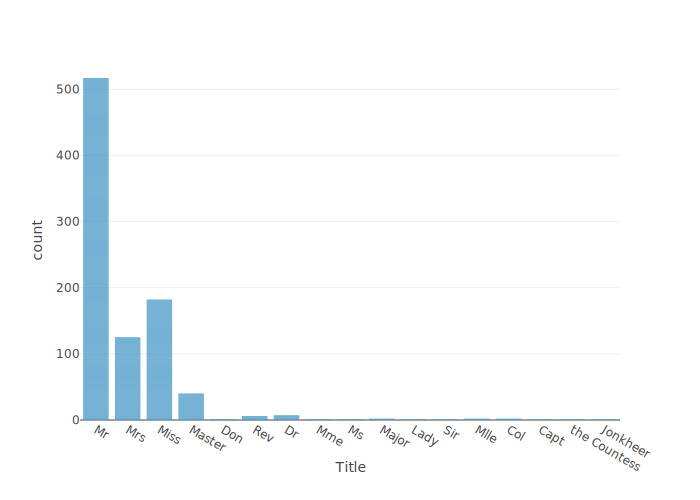

In [11]:
px.bar(data, 'Title')

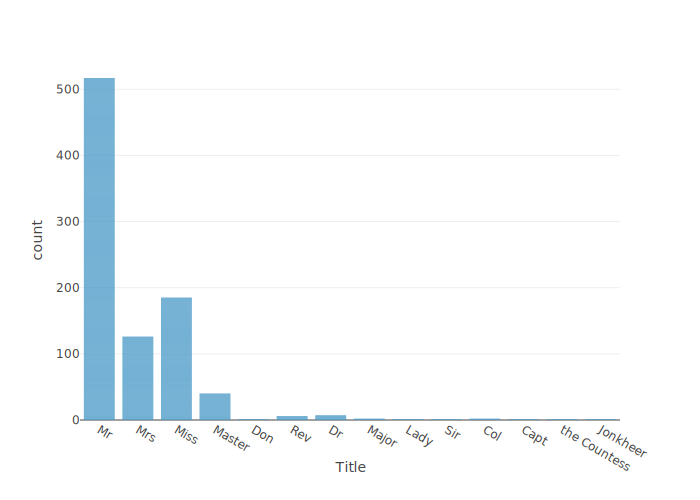

In [12]:
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
px.bar(data, 'Title')

j. Are any of the remaining titles underrepresented among the observations? If it is the case, group them in a unique modality "Rare"

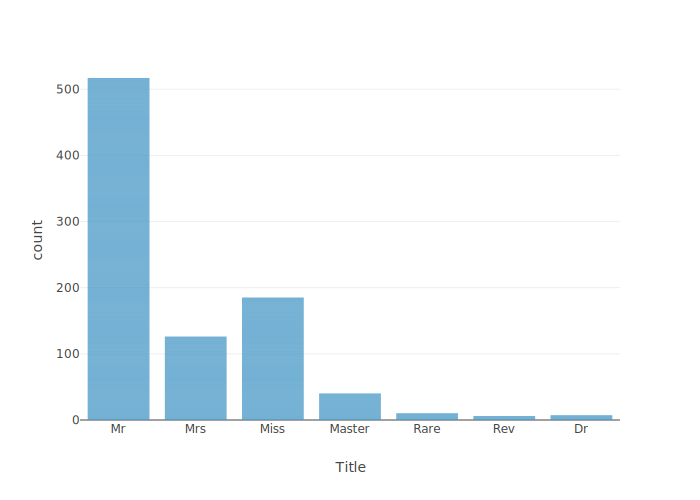

In [13]:
# Group all non-common titles into one single grouping "Rare"
rare_titles = ['Don', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer']
data['Title'] = data['Title'].replace(rare_titles, 'Rare')
px.bar(data, 'Title')

4. Drop the columns 'PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp' du dataset. Why don't we need these columns for what's next?

In [14]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
data = data.drop(drop_elements, axis = 1)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          714 non-null    float64
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Embarked     889 non-null    object 
 7   Name_length  891 non-null    int64  
 8   Has_Cabin    891 non-null    bool   
 9   FamilySize   891 non-null    int64  
 10  IsAlone      891 non-null    bool   
 11  Title        891 non-null    object 
dtypes: bool(2), float64(2), int64(5), object(3)
memory usage: 71.5+ KB


5. Separate the features from the target and split the data between train and test (with random_state = 0)

In [16]:
X = data.drop("Survived", axis=1)
y = data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0)

6. Using the Pipeline and ColumnTransformer, make all the preprocessings at once. Use the [KNN imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to handle the missing values in the numeric variables, and the SimpleImputer for categorical data.

In [17]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Pclass', 'Age', 'Parch', 'Fare', 'Name_length', 'FamilySize']
Found categorical features  ['Sex', 'Embarked', 'Has_Cabin', 'IsAlone', 'Title']


In [18]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) 
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:])

Performing preprocessings on train set...
     Pclass     Sex   Age  Parch    Fare Embarked  Name_length  Has_Cabin  \
671       1    male  31.0      0  52.000        S           22       True   
417       2  female  18.0      2  13.000        S           29      False   
634       3  female   9.0      2  27.900        S           18      False   
323       2  female  22.0      1  29.000        S           51      False   
379       3    male  19.0      0   7.775        S           27      False   

     FamilySize  IsAlone Title  
671           2    False    Mr  
417           3    False  Miss  
634           6    False  Miss  
323           3    False   Mrs  
379           1     True    Mr  
...Done.
[[-1.54562952  0.08277622 -0.46398808  0.35047578 -0.52725961  0.08547193
   1.          0.          1.          1.          0.          0.
   0.          1.          0.          0.          0.        ]
 [-0.35613584 -0.89456241  2.08699167 -0.37942193  0.23157878  0.72699155
   0.      

### Pearson Correlation Heatmap

7. Produce a figure that contains the correlation table for all the explanatory variables of X_train, what do you think?

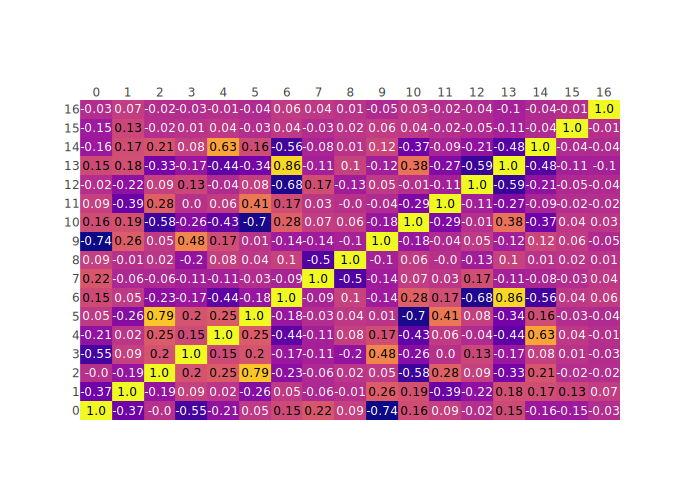

In [19]:
# Correlation matrix
corr_matrix = pd.DataFrame(X_train).corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

**Correlations between the variables are not very high, we can hope that they will each bring complementary information in order to predict the target variable.**

## Ensembling & Stacking models

Now that we have finished our preprocessing and made sure our data was fit for prediction, let's move on to creating our ensemble models. We'll train different models with different ensembling strategies and store their train and test scores for comparison.

### Random Forest
8. Train a Random Forest by tuning the hyperparameters with a grid search. Which ensemble method is related to random forests?

Evaluate the best model's accuracy on train and test sets. Save the scores into a pandas DataFrame.

In [20]:
scores_df = pd.DataFrame(columns = ['model', 'accuracy', 'set'])

In [21]:
# Perform grid search
print("Grid search...")
random_forest = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
print(params)
gridsearch = GridSearchCV(random_forest, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, y_test))
scores_df = scores_df.append({'model': 'random_forest', 'accuracy': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'random_forest', 'accuracy': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df

Grid search...
{'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 5], 'min_samples_split': [2, 4, 8], 'n_estimators': [10, 20, 40, 60, 80, 100]}
Fitting 3 folds for each of 270 candidates, totalling 810 fits
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 10}
Best validation accuracy :  0.8277919174780162

Accuracy on training set :  0.874251497005988
Accuracy on test set :  0.7892376681614349


model  accuracy    set
0  random_forest  0.874251  train
1  random_forest  0.789238   test

9. Create your own Bagging of decision tree (with the same hyperparameters as the optimal ones for Random Forest) and check you get compatible performances.

In [22]:
print('Training Bagging of decision tree...')
decision_tree = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 1, min_samples_split = 4) # Same hyperparameters as best RF model
bagging = BaggingClassifier(base_estimator=decision_tree, n_estimators = 20)
bagging.fit(X_train, y_train)
print("...Done.")
print("Accuracy on training set : ", bagging.score(X_train, y_train))
print("Accuracy on test set : ", bagging.score(X_test, y_test))
scores_df = scores_df.append({'model': 'bagging_dt', 'accuracy': bagging.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'bagging_dt', 'accuracy': bagging.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df

Training Bagging of decision tree...
...Done.
Accuracy on training set :  0.937125748502994
Accuracy on test set :  0.8161434977578476


model  accuracy    set
0  random_forest  0.874251  train
1  random_forest  0.789238   test
2     bagging_dt  0.937126  train
3     bagging_dt  0.816143   test

**The performances are not exactly the same ! However, let's remember that this dataset is quite small, so actually the difference is not significant 😌 (if you're curious: use a cross-validation to estimate the uncertainty on the test scores)**

10. Train an AdaBoost model by tuning the hyperparameters:
* With a logistic regression as base estimator
* With a decision tree as base estimator

For each model, evaluate the performances on the test set.

In [23]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000)
adaboost_logreg = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0],
    'n_estimators': [5, 10, 20, 40, 60, 80, 100]
}
print(params)
gridsearch = GridSearchCV(adaboost_logreg, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, y_test))
scores_df = scores_df.append({'model': 'adaboost_logreg', 'accuracy': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'adaboost_logreg', 'accuracy': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df

Grid search...
{'base_estimator__C': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0], 'n_estimators': [5, 10, 20, 40, 60, 80, 100]}
Fitting 3 folds for each of 56 candidates, totalling 168 fits
...Done.
Best hyperparameters :  {'base_estimator__C': 5.0, 'n_estimators': 60}
Best validation accuracy :  0.8368009264870251

Accuracy on training set :  0.8323353293413174
Accuracy on test set :  0.8026905829596412


model  accuracy    set
0    random_forest  0.874251  train
1    random_forest  0.789238   test
2       bagging_dt  0.937126  train
3       bagging_dt  0.816143   test
4  adaboost_logreg  0.832335  train
5  adaboost_logreg  0.802691   test

In [24]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
adaboost_dt = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [8, 10, 12],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [6, 8, 10],
    'n_estimators': [2, 4, 6, 8, 10, 12]
}
print(params)
gridsearch = GridSearchCV(adaboost_dt, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, y_test))
scores_df = scores_df.append({'model': 'adaboost_dt', 'accuracy': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'adaboost_dt', 'accuracy': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df

Grid search...
{'base_estimator__max_depth': [8, 10, 12], 'base_estimator__min_samples_leaf': [1, 2, 3], 'base_estimator__min_samples_split': [6, 8, 10], 'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 8, 'n_estimators': 8}
Best validation accuracy :  0.7933314480399681

Accuracy on training set :  1.0
Accuracy on test set :  0.8026905829596412


model  accuracy    set
0    random_forest  0.874251  train
1    random_forest  0.789238   test
2       bagging_dt  0.937126  train
3       bagging_dt  0.816143   test
4  adaboost_logreg  0.832335  train
5  adaboost_logreg  0.802691   test
6      adaboost_dt       1.0  train
7      adaboost_dt  0.802691   test

11. Train scikit-learn's GradientBoosting model (by tuning hyperparameters) and evaluate the performances.

In [25]:
# Perform grid search
print("Grid search...")
gradientboost = GradientBoostingClassifier()

# Grid of values to be tested
params = {
    'max_depth': [8, 10, 12],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 8, 10],
    'n_estimators': [2, 4, 6, 8, 10, 12]
}
print(params)
gridsearch = GridSearchCV(gradientboost, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, y_test))
scores_df = scores_df.append({'model': 'gradient_boost', 'accuracy': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'gradient_boost', 'accuracy': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df

Grid search...
{'max_depth': [8, 10, 12], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [6, 8, 10], 'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 12}
Best validation accuracy :  0.8233278121170499

Accuracy on training set :  0.9356287425149701
Accuracy on test set :  0.8475336322869955


model  accuracy    set
0    random_forest  0.874251  train
1    random_forest  0.789238   test
2       bagging_dt  0.937126  train
3       bagging_dt  0.816143   test
4  adaboost_logreg  0.832335  train
5  adaboost_logreg  0.802691   test
6      adaboost_dt       1.0  train
7      adaboost_dt  0.802691   test
8   gradient_boost  0.935629  train
9   gradient_boost  0.847534   test

12. Train an XGBoost model (by tuning hyperparameters). Do you get better or similar results compared to scikit-learn's GradientBoosting?

In [26]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 2, 4, 6, 8],
    'n_estimators': [2, 4, 6, 8, 10, 12]
}
print(params)
gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 3, verbose = 1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, y_test))
scores_df = scores_df.append({'model': 'xgboost', 'accuracy': gridsearch.score(X_train, y_train), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'xgboost', 'accuracy': gridsearch.score(X_test, y_test), 'set': 'test'}, ignore_index = True)
scores_df

Grid search...
{'max_depth': [4, 6, 8, 10], 'min_child_weight': [1, 2, 4, 6, 8], 'n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 3 folds for each of 120 candidates, totalling 360 fits
...Done.
Best hyperparameters :  {'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 6}
Best validation accuracy :  0.8248360468091409

Accuracy on training set :  0.8727544910179641
Accuracy on test set :  0.8251121076233184


model  accuracy    set
0     random_forest  0.874251  train
1     random_forest  0.789238   test
2        bagging_dt  0.937126  train
3        bagging_dt  0.816143   test
4   adaboost_logreg  0.832335  train
5   adaboost_logreg  0.802691   test
6       adaboost_dt       1.0  train
7       adaboost_dt  0.802691   test
8    gradient_boost  0.935629  train
9    gradient_boost  0.847534   test
10          xgboost  0.872754  train
11          xgboost  0.825112   test

13. Compare all the models' performances in a bar chart and conclude. Which model is the best?

Hint: the option `barmode` in plotly's `px.bar()` might be useful 😇

In [27]:
scores_df = scores_df.sort_values(by = ['set', 'accuracy'], ascending = False)
scores_df

model  accuracy    set
6       adaboost_dt       1.0  train
2        bagging_dt  0.937126  train
8    gradient_boost  0.935629  train
0     random_forest  0.874251  train
10          xgboost  0.872754  train
4   adaboost_logreg  0.832335  train
9    gradient_boost  0.847534   test
11          xgboost  0.825112   test
3        bagging_dt  0.816143   test
5   adaboost_logreg  0.802691   test
7       adaboost_dt  0.802691   test
1     random_forest  0.789238   test

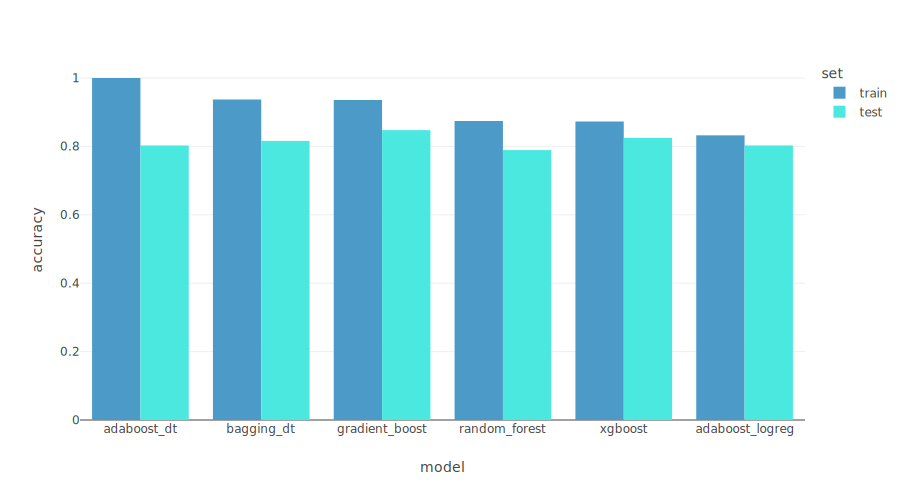

In [28]:
px.bar(scores_df, x = "model", y = 'accuracy', color = 'set', barmode = 'group', width = 900)

**The gradient boosting model seems to be a bit better than the other ones: it has the best test accuracy and still doesn't overfit that much.**